#  Homework 5 - Berkeley STAT 157

**Your name: Zhiming, SID 3034485754** (Please add your name, and SID to ease Ryan and Rachel to grade.)

**Please submit your homework through [gradescope](http://gradescope.com/) instead of Github, so you will get the score distribution for each question. Please enroll in the [class](https://www.gradescope.com/courses/42432) by the Entry code: MXG5G5** 

Handout 2/19/2019, due 2/26/2019 by 4pm in Git by committing to your repository.

In this homework, we will model covariate shift and attempt to fix it using logistic regression. This is a fairly realistic scenario for data scientists. To keep things well under control and understandable we will use [Fashion-MNIST](http://d2l.ai/chapter_linear-networks/fashion-mnist.html) as the data to experiment on. 

Follow the instructions from the Fashion MNIST notebook to get the data.

In [1]:
%matplotlib inline
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, utils
import d2l
import numpy as np
import matplotlib.pyplot as plt
import mxnet as mx
import time

## 1. Logistic Regression

1. Implement the logistic loss function $l(y,f) = -\log(1 + \exp(-y f))$ in Gluon.
2. Plot its values and its derivative for $y = 1$ and $f \in [-5, 5]$, using automatic differentiation in Gluon.
3. Generate training and test datasets for a binary classification problem using Fashion-MNIST with class $1$ being a combination of `shirt` and `sweater` and class $-1$ being the combination of `sandal` and `sneaker` categories. 
4. Train a binary classifier of your choice (it can be linear or a simple MLP such as from a previous lecture) using half the data (i.e. $12,000$ observations mixed as abvove) and one using the full dataset (i.e. $24,000$ observations as arising from the 4 categories) and report its accuracy. 

Hint - you should encapsulate the training and reporting code in a callable function since you'll need it quite a bit in the following. 

(1000,) (1000,)
(1000,)


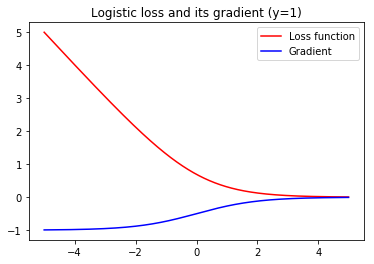

In [96]:
# for question 1 & 2
def logistic_loss(f, y):
    l = nd.log(1.0+nd.exp(-f*y))
    return l
f = nd.arange(-5, 5, 0.01)
f.attach_grad()
# for y = 1
y = nd.ones(shape = f.shape)
with autograd.record():
    l = logistic_loss(f, y)
l.backward()
# for loss function
plt.figure()
plt.title('Logistic loss and its gradient (y=1)')
plt.plot(f.asnumpy(), l.asnumpy(), color = 'r',\
         label = 'Loss function')
# for grad
plt.plot(f.asnumpy(), f.grad.asnumpy(), color = 'b',\
        label = 'Gradient')
plt.legend(loc = 'upper right')
plt.show()

In [5]:
mnist_train = gdata.vision.FashionMNIST(train=True, transform = lambda data, label:\
                                        (data.astype(np.float32), label))
mnist_test = gdata.vision.FashionMNIST(train=False, transform = lambda data, label:\
                                        (data.astype(np.float32), label))

In [13]:
# for question 3
#X, y = train[0:9]
# pick out pullover/shirt, and sneaker/scandal
# a new preprocess function, can produce biased dataset
def preprocess(mnist_train, mnist_test, total_per_label, ratio): # ratio is the lambda above
    X, y = mnist_train[:]
    # pick up the indices
    index_sweater = np.where(y==3)[0]
    index_shirt = np.where(y==6)[0]
    index_scandal = np.where(y==5)[0]
    index_sneaker = np.where(y==7)[0]
    # create the class for training, biased
    class_sweater = X[index_sweater[0:round(total_per_label*ratio)]]
    class_shirt = X[index_shirt[0:round(total_per_label*ratio)]]
    class_scandal = X[index_scandal[0:round(total_per_label*(1-ratio))]]
    class_sneaker = X[index_sneaker[0:round(total_per_label*(1-ratio))]]
    # print(class_sweater.shape, class_shirt.shape, class_scandal.shape, class_sneaker.shape)
    train_feature = nd.concat(class_sweater, class_shirt, class_scandal, class_sneaker, dim=0)
    
    label1 = nd.ones((1, total_per_label)).astype(np.float32)
    label2 = nd.zeros((1, total_per_label)).astype(np.float32)
    train_labels = nd.concat(label1, label2, dim=1).reshape(shape=(-1,))
    train_data = gdata.dataset.ArrayDataset(train_feature, train_labels)
    # create the class for testing, unbiased
    X, y = mnist_test[:]
    index1 = np.where(np.logical_or(y==3, y==6))[0]
    index2 = np.where(np.logical_or(y==5, y==7))[0]
    class1 = X[index1]
    class2 = X[index2]
    test_feature = nd.concat(class1, class2, dim=0)
    
    label1 = nd.ones((1, 2000)).astype(np.float32)
    label2 = nd.zeros((1, 2000)).astype(np.float32)
    test_labels = nd.concat(label1, label2, dim=1).reshape(shape=(-1,))
    test_data = gdata.dataset.ArrayDataset(test_feature, test_labels)
    
    return train_data, test_data

In [14]:
def train_and_test_mnist(train_data, test_data, batch_size, lr, num_epochs):
    net = nn.Sequential()
    net.add(nn.Dense(2))
    net.initialize(init.Normal(sigma=0.01))
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    #loss = logistic_loss
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
    d2l.train_ch3(net, train_data, test_data, loss, num_epochs, batch_size, None, None, trainer)

In [15]:
# half the dataset 
# note: use half the dataset, test acc is almost the same as using the full dataset
# so I used just 50 per label for train (total 100 for training), which leads to
# observable difference in test acc (~.975 v.s. ~.999)
train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label=50, ratio=0.5) # ratio=.5 for equally division
batch_size = 64
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_and_test_mnist(train_data, test_data, batch_size=batch_size, lr=0.1, num_epochs=5)
# full dataset
train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label=12000, ratio=0.5) # ration=.5 for equally division
batch_size = 64
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_and_test_mnist(train_data, test_data, batch_size=batch_size, lr=0.1, num_epochs=5)

epoch 1, loss 16637.0955, train acc 0.420, test acc 0.911
epoch 2, loss 1097.2720, train acc 0.960, test acc 0.950
epoch 3, loss 239.5708, train acc 0.990, test acc 0.953
epoch 4, loss 140.1334, train acc 0.990, test acc 0.958
epoch 5, loss 40.6960, train acc 0.990, test acc 0.963
epoch 1, loss 461.2452, train acc 0.993, test acc 0.998
epoch 2, loss 24.4931, train acc 0.999, test acc 0.999
epoch 3, loss 13.6120, train acc 0.999, test acc 0.999
epoch 4, loss 8.5127, train acc 0.999, test acc 0.999
epoch 5, loss 10.3028, train acc 0.999, test acc 0.999


## 2. Covariate Shift

Your goal is to introduce covariate shit in the data and observe the accuracy. For this, compose a dataset of $12,000$ observations, given by a mixture of `shirt` and `sweater` and of `sandal` and `sneaker` respectively, where you use a fraction $\lambda \in \{0.05, 0.1, 0.2, \ldots 0.8, 0.9, 0.95\}$ of one and a fraction of $1-\lambda$ of  the other datasets respectively. For instance, you might pick for $\lambda = 0.1$ a total of $600$ `shirt` and $600$ `sweater` images and likewise $5,400$ `sandal` and $5,400$ `sneaker` photos, yielding a total of $12,000$ images for training. Note that the test set remains unbiased, composed of $2,000$ photos for the `shirt` + `sweater` category and of the `sandal` + `sneaker` category each.

1. Generate training sets that are appropriately biased. You should have 11 datasets.
2. Train a binary classifier using this and report the test set accuracy on the unbiased test set. 

In [27]:
total_per_label = 6000
num_epochs = 5
print("Bias ratio now is:", .05)
train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label=total_per_label, ratio=0.05)
batch_size = 64
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_and_test_mnist(train_data, test_data, batch_size=batch_size, lr=0.01, num_epochs=num_epochs)
for r in range(1, 9, 1):
    ratio = r / 10.0
    print("Bias ratio now is:", ratio, "(unbiased)" if ratio==.5 else "")
    train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label=total_per_label, ratio=ratio)
    batch_size = 64
    train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    train_and_test_mnist(train_data, test_data, batch_size=batch_size, lr=0.01, num_epochs=num_epochs)
print("Bias ratio now is:", .95)
train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label=total_per_label, ratio=0.95)
batch_size = 64
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_and_test_mnist(train_data, test_data, batch_size=batch_size, lr=0.01, num_epochs=num_epochs)

Bias ratio now is: 0.05
epoch 1, loss 988.9615, train acc 0.825, test acc 0.709
epoch 2, loss 452.8739, train acc 0.878, test acc 0.790
epoch 3, loss 455.8028, train acc 0.882, test acc 0.743
epoch 4, loss 485.5297, train acc 0.885, test acc 0.783
epoch 5, loss 451.8702, train acc 0.879, test acc 0.756
Bias ratio now is: 0.1 
epoch 1, loss 1028.6509, train acc 0.802, test acc 0.770
epoch 2, loss 700.9965, train acc 0.842, test acc 0.808
epoch 3, loss 673.2709, train acc 0.846, test acc 0.826
epoch 4, loss 649.5951, train acc 0.846, test acc 0.786
epoch 5, loss 632.5607, train acc 0.846, test acc 0.790
Bias ratio now is: 0.2 
epoch 1, loss 1074.8852, train acc 0.776, test acc 0.943
epoch 2, loss 827.0725, train acc 0.798, test acc 0.763
epoch 3, loss 825.1936, train acc 0.800, test acc 0.747
epoch 4, loss 738.3895, train acc 0.811, test acc 0.809
epoch 5, loss 740.9231, train acc 0.808, test acc 0.975
Bias ratio now is: 0.3 
epoch 1, loss 917.2764, train acc 0.785, test acc 0.858
epoch 

## 3. Covariate Shift Correction

Having observed that covariate shift can be harmful, let's try fixing it. For this we first need to compute the appropriate propensity scores $\frac{dp(x)}{dq(x)}$. For this purpose pick a biased dataset, let's say with $\lambda = 0.1$ and try to fix the covariate shift.

1. When training a logistic regression binary classifier to fix covariate shift, we assumed so far that both sets are of equal size. Show that re-weighting data in training and test set appropriately can help address the issue when both datasets have different size. What is the weighting?
2. Train a binary classifier (using logistic regression) distinguishing between the biased training set and the unbiased test set. Note - you need to weigh the data. 
3. Use the scores to compute weights on the training set. Do they match the weight arising from the biasing distribution $\lambda$? 
4. Train a binary classifier of the covariate shifted problem using the weights obtained previously and report the accuracy. Note - you will need to modify the training loop slightly such that you can compute the gradient of a weighted sum of losses. 


In [10]:
# loss function with ratio
def logistic_loss(f, y):
    f = f.reshape(shape=y.shape)
    # weight = nd.zeros(shape=y.shape)
    # weight[np.where(y==1)[0]] = .5/ratio
    # weight[np.where(y==-1)[0]] = .5/(1-ratio)
    #l = weight * nd.log(1.0+nd.exp(-y*f))
    l = nd.log(nd.ones(shape=y.shape)+nd.exp(-f*y))
    return l
# calculate acc per epoch
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        y = y.astype('float32')
        acc_sum += (nd.sign(net(X)) == y).sum().asscalar()
        n += y.size
    return acc_sum / n
# train weighted version
def train_weighted(net, train_iter, test_iter, num_epochs, batch_size, trainer, ratio):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = logistic_loss(y_hat, y).sum()
            l.backward()
            trainer.step(batch_size)
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))
# convenient api for train and test
def train_and_test_mnist(train_data, test_data, batch_size, lr, num_epochs, ratio):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=0.01))
    #loss = logistic_loss
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
    train_weighted(net, train_data, test_data, num_epochs, batch_size, trainer, ratio)
# a new preprocess procedure, -1/1 for two labels
def preprocess(mnist_train, mnist_test, total_per_label, ratio): # ration is the lambda above
    X, y = mnist_train[:]
    # pick up the indices
    index_sweater = np.where(y==3)[0]
    index_shirt = np.where(y==6)[0]
    index_scandal = np.where(y==5)[0]
    index_sneaker = np.where(y==7)[0]
    # create the class for training, biased
    class_sweater = X[index_sweater[0:round(total_per_label*ratio)]]
    class_shirt = X[index_shirt[0:round(total_per_label*ratio)]]
    class_scandal = X[index_scandal[0:round(total_per_label*(1-ratio))]]
    class_sneaker = X[index_sneaker[0:round(total_per_label*(1-ratio))]]
    # print(class_sweater.shape, class_shirt.shape, class_scandal.shape, class_sneaker.shape)
    train_feature = nd.concat(class_sweater, class_shirt, class_scandal, class_sneaker, dim=0)
    
    label1 = nd.ones((1, total_per_label)).astype(np.float32)
    label2 = -nd.ones((1, total_per_label)).astype(np.float32)
    train_labels = nd.concat(label1, label2, dim=1).reshape(shape=(-1,))
    train_data = gdata.dataset.ArrayDataset(train_feature, train_labels)
    # create the class for testing, unbiased
    X, y = mnist_test[:]
    index1 = np.where(np.logical_or(y==3, y==6))[0]
    index2 = np.where(np.logical_or(y==5, y==7))[0]
    class1 = X[index1]
    class2 = X[index2]
    test_feature = nd.concat(class1, class2, dim=0)
    
    label1 = nd.ones((1, 2000)).astype(np.float32)
    label2 = -nd.ones((1, 2000)).astype(np.float32)
    test_labels = nd.concat(label1, label2, dim=1).reshape(shape=(-1,))
    test_data = gdata.dataset.ArrayDataset(test_feature, test_labels)
    
    return train_data, test_data

In [11]:
total_per_label = 300
ratio = 0.9
num_epochs = 5
train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label, ratio)
batch_size = 64
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_and_test_mnist(train_data, test_data, batch_size=batch_size, lr=0.001, num_epochs=num_epochs, ratio=ratio)

epoch 1, loss nan, train acc 0.000, test acc 0.000
epoch 2, loss nan, train acc 0.000, test acc 0.000
epoch 3, loss nan, train acc 0.000, test acc 0.000
epoch 4, loss nan, train acc 0.000, test acc 0.000
epoch 5, loss nan, train acc 0.000, test acc 0.000
